# Sentiment Analysis with Word2Vec and XGBoost

## Software Requirements

- python 3.6.5
- numpy 1.14.2
- panda 0.22.0
- gensim 3.4.0

In [10]:
import sys
import numpy as np
import pandas as pd
import gensim

print("python: {}".format(sys.version))
print("numpy: {}".format(np.version.version))
print("panda: {}".format(pd.__version__))
print("gensim: {}".format(gensim.__version__))

python: 3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
numpy: 1.14.2
panda: 0.22.0
gensim: 3.4.0


## Dataset

The dataset used in this project can be found at <a href="http://ai.stanford.edu/~amaas/data/sentiment/">Large Movie Review Dataset</a> \[1\]. For convenience, the files from the dataset have been concatenated into labeled_train.csv, unlabled_train.csv, and labeled_test.csv compressed in dataset.zip. Unzip dataset.zip before running this project.

#### Reference

\[1\] Andrew  L.  Maas,  Raymond  E.  Daly,  Peter  T.  Pham,  Dan  Huang,  An-drew Y. Ng, and Christopher Potts.  Learning word vectors for sentimentanalysis.   InProceedings of the 49th Annual Meeting of the Associationfor Computational Linguistics: Human Language Technologies, pages 142–150,  Portland,  Oregon,  USA,  June  2011.  Association  for  ComputationalLinguistics.

In [11]:
# Read train/test datasets
from gensim.utils import simple_preprocess
import pandas as pd
import numpy as np
import logging
import warnings

# Enable logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Ignore deprecation warning for concision
# Please see https://github.com/scikit-learn/scikit-learn/issues/10449
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore')


# This method tokenizes each comment into lowercase token array.
# gensim.utils.simple_preprocess ignores tokens that are too short or too long (min_len=2, max_len=15 by default).
def preprocess(comments):
    return np.array([simple_preprocess(c) for c in np.array(comments)])


# Load training and test sets and apply the basic preprocessing. 
labeled_train = pd.read_csv("dataset/labeled_train.csv", sep='\t', header=None, names=['sentiment', 'comment'])
X_train = preprocess(labeled_train['comment'])
y_train = np.array(labeled_train['sentiment'])

labeled_test = pd.read_csv("dataset/labeled_test.csv", sep='\t', header=None, names=['sentiment', 'comment'])
X_test = preprocess(labeled_test['comment'])
y_test = np.array(labeled_test['sentiment'])

unlabeled_train = pd.read_csv("dataset/unlabeled_train.csv", sep='\t', header=None, names=['comment'])
Z_train = preprocess(unlabeled_train['comment'])

# Use both labeled and unlabeled training sets to improve word2vec model accuracy.
comments = []
   
for i in range(0, len(X_train)):
    comments.append(X_train[i])

for i in range(0, len(Z_train)):
    comments.append(Z_train[i])


print("Unlabeled train size: {}".format(unlabeled_train.shape[0]))
print("Labeled train size: {}".format(X_train.shape[0]))
print("Labeled test size: {}".format(X_train.shape[0]))
print("Word2Vec train size: {}".format(len(comments)))

Unlabeled train size: 50000
Labeled train size: 25000
Labeled test size: 25000
Word2Vec train size: 75000


## Data Exploration

### Sample Reviews

In [37]:
print("========== Positive Review Samples ==========")

for i in range(0, 10):
    print("{} \t {}".format(labeled_train['sentiment'][i], labeled_train['comment'][i]))
    
print("========== Negative Review Samples ==========")

for j in range(12500, 12510):
    print("{} \t {}".format(labeled_train['sentiment'][j], labeled_train['comment'][j]))

========== Positive Review Samples ==========
1 	 Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!
1 	 Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were 

### Token Count Statistics

In [56]:
import numpy as np

# Count number of tokens for each comment for training data
trainLens = []

for i in range(0, X_train.shape[0]):
    trainLens.append(len(labeled_train['comment'][i].split()))

print("===== Train Statistics =====")
print("Min: {}".format(np.amin(trainLens)))
print("Max: {}".format(np.amax(trainLens)))
print("Mean: {}".format(np.mean(trainLens)))
print("Median: {}".format(np.median(trainLens)))
print("Std: {}".format(np.std(trainLens)))

===== Train Statistics =====
Min: 5
Max: 2470
Mean: 233.51256
Median: 174.0
Std: 173.36922103489533


### Most Common 50 Words

In [4]:
from collections import Counter

wordCounter = Counter()

for i in range(0, len(comments)):
    wordCounter.update(comments[i])

wordCounter.most_common(50)

[('the', 1013857),
 ('and', 493424),
 ('of', 439103),
 ('to', 406655),
 ('is', 321239),
 ('br', 306353),
 ('it', 287579),
 ('in', 282460),
 ('this', 226547),
 ('that', 218562),
 ('was', 144097),
 ('as', 139772),
 ('with', 133669),
 ('for', 133469),
 ('movie', 132122),
 ('but', 126814),
 ('film', 121074),
 ('you', 103731),
 ('on', 101756),
 ('not', 90723),
 ('he', 89881),
 ('are', 89063),
 ('his', 87763),
 ('have', 83511),
 ('be', 81470),
 ('one', 81220),
 ('all', 71046),
 ('at', 69981),
 ('they', 69879),
 ('by', 68133),
 ('who', 65078),
 ('an', 64962),
 ('from', 62325),
 ('so', 61943),
 ('like', 60925),
 ('there', 57259),
 ('her', 54495),
 ('or', 54161),
 ('just', 53550),
 ('about', 52042),
 ('out', 51384),
 ('has', 50718),
 ('if', 50464),
 ('what', 48320),
 ('some', 47775),
 ('good', 44843),
 ('can', 43900),
 ('more', 42616),
 ('when', 42563),
 ('very', 41810)]

### Smiley Emoji

In [5]:
from collections import Counter

# Keep track the number of smiley faces in each label
smileyCounter = Counter()

for i in range(0, len(labeled_train['comment'])):
    if ":-)" in labeled_train['comment'][i]: 
        smileyCounter[y_train[i]] += 1
    
print(smileyCounter)

Counter({1: 29, 0: 21})


### Word Distribution

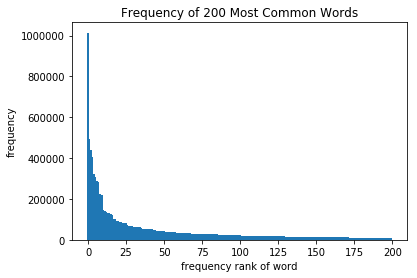

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the distribution of 200 most common words
labels, values = zip(*wordCounter.most_common(200))
indexes = np.arange(len(labels))
width = 1

plt.title("Frequency of 200 Most Common Words")
plt.xlabel('frequency rank of word')
plt.ylabel('frequency')
plt.bar(indexes, values, width)
plt.show()

## Data Transformation

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.utils import simple_preprocess
from collections import defaultdict

class MeanWordVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.wv.get_vector('incredible'))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec.wv.vocab]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

## Default Run

In [18]:
documents_default = []

for i in range(0, len(comments)):
    documents_default.append([ w for w in comments[i]])

In [19]:
from gensim.models import Word2Vec

word2vec_default = Word2Vec(documents_default)
word2vec_default.train(documents, total_examples=len(documents_default), epochs=10)

2018-09-01 20:31:59,760 : INFO : collecting all words and their counts
2018-09-01 20:31:59,761 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-09-01 20:32:00,114 : INFO : PROGRESS: at sentence #10000, processed 2280736 words, keeping 49391 word types
2018-09-01 20:32:00,467 : INFO : PROGRESS: at sentence #20000, processed 4511766 words, keeping 66818 word types
2018-09-01 20:32:00,836 : INFO : PROGRESS: at sentence #30000, processed 6775545 words, keeping 79713 word types
2018-09-01 20:32:01,212 : INFO : PROGRESS: at sentence #40000, processed 9081000 words, keeping 90678 word types
2018-09-01 20:32:01,582 : INFO : PROGRESS: at sentence #50000, processed 11352902 words, keeping 100450 word types
2018-09-01 20:32:01,948 : INFO : PROGRESS: at sentence #60000, processed 13579732 words, keeping 108925 word types
2018-09-01 20:32:02,312 : INFO : PROGRESS: at sentence #70000, processed 15847194 words, keeping 117057 word types
2018-09-01 20:32:02,494 : INFO : 

2018-09-01 20:32:48,479 : INFO : EPOCH 5 - PROGRESS: at 57.31% examples, 1220694 words/s, in_qsize 5, out_qsize 0
2018-09-01 20:32:49,484 : INFO : EPOCH 5 - PROGRESS: at 67.39% examples, 1230609 words/s, in_qsize 6, out_qsize 0
2018-09-01 20:32:50,491 : INFO : EPOCH 5 - PROGRESS: at 77.74% examples, 1237898 words/s, in_qsize 6, out_qsize 0
2018-09-01 20:32:51,494 : INFO : EPOCH 5 - PROGRESS: at 87.87% examples, 1246358 words/s, in_qsize 5, out_qsize 0
2018-09-01 20:32:52,502 : INFO : EPOCH 5 - PROGRESS: at 97.67% examples, 1245455 words/s, in_qsize 5, out_qsize 0
2018-09-01 20:32:52,780 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-01 20:32:52,784 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-01 20:32:52,785 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-01 20:32:52,786 : INFO : EPOCH - 5 : training on 16974301 raw words (12837961 effective words) took 10.4s, 1240285 effective words/s
2018-09-01 20:32

2018-09-01 20:33:38,054 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-01 20:33:38,059 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-01 20:33:38,070 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-01 20:33:38,071 : INFO : EPOCH - 6 : training on 9908215 raw words (9789005 effective words) took 7.6s, 1291054 effective words/s
2018-09-01 20:33:39,076 : INFO : EPOCH 7 - PROGRESS: at 12.95% examples, 1274865 words/s, in_qsize 5, out_qsize 0
2018-09-01 20:33:40,089 : INFO : EPOCH 7 - PROGRESS: at 26.03% examples, 1261036 words/s, in_qsize 5, out_qsize 2
2018-09-01 20:33:41,089 : INFO : EPOCH 7 - PROGRESS: at 38.13% examples, 1231924 words/s, in_qsize 5, out_qsize 0
2018-09-01 20:33:42,093 : INFO : EPOCH 7 - PROGRESS: at 51.25% examples, 1252568 words/s, in_qsize 5, out_qsize 0
2018-09-01 20:33:43,095 : INFO : EPOCH 7 - PROGRESS: at 62.21% examples, 1217089 words/s, in_qsize 5, out_qsize 0
2018-09-01 20:33:44

(97890050, 99082150)

In [20]:
from sklearn.model_selection import train_test_split

vectorizer_default = MeanWordVectorizer(word2vec_default)
X1_default = vectorizer_default.transform(X_train)
X2_default = vectorizer_default.transform(X_test)

X_train_default, X_test_default, y_train_default, y_test_default = train_test_split(X1_default, y_train, test_size=0.2, random_state=42)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic = LogisticRegression()
logistic.fit(X_train_default, y_train_default)
y_pred = logistic.predict(X_test_default)
accuracy = accuracy_score(y_test_default, y_pred)

print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Test Accuracy: 85.48%


In [22]:
from xgboost.sklearn import XGBClassifier

xgboost = XGBClassifier()
xgboost.fit(X_train_default, y_train_default)
y_pred = xgboost.predict(X_test_default)
accuracy = accuracy_score(y_test_default, y_pred)

print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Test Accuracy: 80.56%


## Unsupervised Learning

### Word2Vec

#### Remove Stop Words

In [8]:
# Define top common 50 words as stop words
stop_words = {*()}

for c in wordCounter.most_common(50):
    stop_words.add(c[0])

# Drop stop words
documents = []

for i in range(0, len(comments)):
    documents.append([ w for w in comments[i] if w not in stop_words ])

# Confirm the stop words are discarded
print(documents[1])

['homelessness', 'houselessness', 'george', 'carlin', 'stated', 'been', 'issue', 'years', 'never', 'plan', 'help', 'those', 'street', 'were', 'once', 'considered', 'human', 'did', 'everything', 'going', 'school', 'work', 'vote', 'matter', 'most', 'people', 'think', 'homeless', 'lost', 'cause', 'while', 'worrying', 'things', 'such', 'racism', 'war', 'iraq', 'pressuring', 'kids', 'succeed', 'technology', 'elections', 'inflation', 'worrying', 'll', 'next', 'end', 'up', 'streets', 'were', 'given', 'bet', 'live', 'streets', 'month', 'without', 'luxuries', 'once', 'had', 'home', 'entertainment', 'sets', 'bathroom', 'pictures', 'wall', 'computer', 'everything', 'once', 'treasure', 'see', 'homeless', 'goddard', 'bolt', 'lesson', 'mel', 'brooks', 'directs', 'stars', 'bolt', 'plays', 'rich', 'man', 'everything', 'world', 'until', 'deciding', 'make', 'bet', 'sissy', 'rival', 'jeffery', 'tambor', 'see', 'live', 'streets', 'thirty', 'days', 'without', 'luxuries', 'bolt', 'succeeds', 'do', 'wants', 

#### Tuned Word2Vec Model

In [85]:
from gensim.models import Word2Vec

# Train word2vec model
word2vec = Word2Vec(documents, size=200, window=12, min_count=2, sg=0, cbow_mean=1, hs=0, negative=5, workers=10)
word2vec.train(documents, total_examples=len(documents), epochs=10)

# Uncomment to save the trained word2vec model
#word2vec.save('saved/cbow')

2018-08-23 17:05:29,856 : INFO : collecting all words and their counts
2018-08-23 17:05:29,857 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-08-23 17:05:30,130 : INFO : PROGRESS: at sentence #10000, processed 1334470 words, keeping 49341 word types
2018-08-23 17:05:30,388 : INFO : PROGRESS: at sentence #20000, processed 2634865 words, keeping 66768 word types
2018-08-23 17:05:30,653 : INFO : PROGRESS: at sentence #30000, processed 3956185 words, keeping 79663 word types
2018-08-23 17:05:30,937 : INFO : PROGRESS: at sentence #40000, processed 5306842 words, keeping 90628 word types
2018-08-23 17:05:31,217 : INFO : PROGRESS: at sentence #50000, processed 6631278 words, keeping 100400 word types
2018-08-23 17:05:31,487 : INFO : PROGRESS: at sentence #60000, processed 7929119 words, keeping 108875 word types
2018-08-23 17:05:31,771 : INFO : PROGRESS: at sentence #70000, processed 9251238 words, keeping 117007 word types
2018-08-23 17:05:31,915 : INFO : col

2018-08-23 17:06:04,297 : INFO : EPOCH 4 - PROGRESS: at 22.28% examples, 1078216 words/s, in_qsize 19, out_qsize 0
2018-08-23 17:06:05,309 : INFO : EPOCH 4 - PROGRESS: at 33.61% examples, 1079614 words/s, in_qsize 18, out_qsize 1
2018-08-23 17:06:06,315 : INFO : EPOCH 4 - PROGRESS: at 44.78% examples, 1082601 words/s, in_qsize 18, out_qsize 1
2018-08-23 17:06:07,323 : INFO : EPOCH 4 - PROGRESS: at 55.78% examples, 1081581 words/s, in_qsize 18, out_qsize 1
2018-08-23 17:06:08,325 : INFO : EPOCH 4 - PROGRESS: at 66.67% examples, 1077266 words/s, in_qsize 19, out_qsize 0
2018-08-23 17:06:09,335 : INFO : EPOCH 4 - PROGRESS: at 78.31% examples, 1079825 words/s, in_qsize 18, out_qsize 1
2018-08-23 17:06:10,339 : INFO : EPOCH 4 - PROGRESS: at 89.45% examples, 1081344 words/s, in_qsize 19, out_qsize 0
2018-08-23 17:06:11,206 : INFO : worker thread finished; awaiting finish of 9 more threads
2018-08-23 17:06:11,209 : INFO : worker thread finished; awaiting finish of 8 more threads
2018-08-23 17

2018-08-23 17:06:42,174 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-08-23 17:06:42,182 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-08-23 17:06:42,186 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-08-23 17:06:42,186 : INFO : EPOCH - 2 : training on 9908215 raw words (9712748 effective words) took 11.6s, 838859 effective words/s
2018-08-23 17:06:43,206 : INFO : EPOCH 3 - PROGRESS: at 8.27% examples, 803025 words/s, in_qsize 19, out_qsize 0
2018-08-23 17:06:44,247 : INFO : EPOCH 3 - PROGRESS: at 17.83% examples, 849667 words/s, in_qsize 16, out_qsize 3
2018-08-23 17:06:45,271 : INFO : EPOCH 3 - PROGRESS: at 29.01% examples, 913539 words/s, in_qsize 18, out_qsize 1
2018-08-23 17:06:46,291 : INFO : EPOCH 3 - PROGRESS: at 40.54% examples, 958752 words/s, in_qsize 17, out_qsize 2
2018-08-23 17:06:47,300 : INFO : EPOCH 3 - PROGRESS: at 51.32% examples, 980280 words/s, in_qsize 18, out_qsize 1
2018-08-23 17:06:48,

2018-08-23 17:07:22,608 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-08-23 17:07:22,616 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-08-23 17:07:22,628 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-08-23 17:07:22,629 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-08-23 17:07:22,632 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-08-23 17:07:22,633 : INFO : EPOCH - 6 : training on 9908215 raw words (9712217 effective words) took 9.6s, 1011738 effective words/s
2018-08-23 17:07:23,643 : INFO : EPOCH 7 - PROGRESS: at 10.90% examples, 1059928 words/s, in_qsize 20, out_qsize 1
2018-08-23 17:07:24,652 : INFO : EPOCH 7 - PROGRESS: at 22.38% examples, 1078306 words/s, in_qsize 19, out_qsize 0
2018-08-23 17:07:25,657 : INFO : EPOCH 7 - PROGRESS: at 33.42% examples, 1072881 words/s, in_qsize 18, out_qsize 1
2018-08-23 17:07:26,665 : INFO : EPOCH 7 - PROGRESS: at 44.71%

2018-08-23 17:08:02,983 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-08-23 17:08:02,985 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-08-23 17:08:02,986 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-08-23 17:08:03,014 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-08-23 17:08:03,016 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-08-23 17:08:03,020 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-08-23 17:08:03,024 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-08-23 17:08:03,029 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-08-23 17:08:03,029 : INFO : EPOCH - 10 : training on 9908215 raw words (9712597 effective words) took 9.5s, 1022861 effective words/s
2018-08-23 17:08:03,030 : INFO : training on a 99082150 raw words (97129072 effective words) took 102.1s, 951297 effective words/s


(97129072, 99082150)

#### Load from Saved Model

In [9]:
from gensim.models import Word2Vec

# Load previously saved word2vec model
word2vec = Word2Vec.load('saved/cbow')

print("Vocabulary size: {}".format(len(word2vec.wv.vocab)))

2018-09-03 13:29:06,421 : INFO : loading Word2Vec object from saved/cbow
2018-09-03 13:29:07,047 : INFO : loading wv recursively from saved/cbow.wv.* with mmap=None
2018-09-03 13:29:07,047 : INFO : loading vectors from saved/cbow.wv.vectors.npy with mmap=None
2018-09-03 13:29:07,071 : INFO : setting ignored attribute vectors_norm to None
2018-09-03 13:29:07,072 : INFO : loading vocabulary recursively from saved/cbow.vocabulary.* with mmap=None
2018-09-03 13:29:07,072 : INFO : loading trainables recursively from saved/cbow.trainables.* with mmap=None
2018-09-03 13:29:07,073 : INFO : loading syn1neg from saved/cbow.trainables.syn1neg.npy with mmap=None
2018-09-03 13:29:07,097 : INFO : setting ignored attribute cum_table to None
2018-09-03 13:29:07,098 : INFO : loaded saved/cbow


Vocabulary size: 74203


#### Word Similarity

In [28]:
print(word2vec.wv.similarity('favorite', 'favorites'))
print(word2vec.wv.similarity('awesome', 'wonderful'))
print(word2vec.wv.similarity('incredible', 'amazing'))
print(word2vec.wv.similarity('stunning', 'breathtaking'))
print(word2vec.wv.similarity('bad', 'terrible'))
print(word2vec.wv.similarity('unbearable', 'unacceptable'))

0.8038068576153075
0.4181480684981068
0.7529960203405847
0.740081930496738
0.683098283886495
0.24792129284983383


In [29]:
print(word2vec.wv.similarity('amazing', 'sucks'))
print(word2vec.wv.similarity('astounding', 'aweful'))
print(word2vec.wv.similarity('unbelievable', 'unimpressive'))
print(word2vec.wv.similarity('excellent', 'poor'))
print(word2vec.wv.similarity('positive', 'negative'))
print(word2vec.wv.similarity('dirty', 'clean'))

0.2599207420321007
0.10009993877336461
0.200659301012579
0.24772303689030775
0.7419782476344514
0.1622880533422858


In [30]:
word2vec.wv.most_similar(positive='recommend', topn=8)

2018-08-28 13:18:58,076 : INFO : precomputing L2-norms of word weight vectors


[('recommended', 0.7928755283355713),
 ('advise', 0.7442986965179443),
 ('suggest', 0.7286475896835327),
 ('reccomend', 0.7021902203559875),
 ('unrecommended', 0.6527540683746338),
 ('recomend', 0.632939338684082),
 ('recommendable', 0.5861150026321411),
 ('reccomended', 0.5715225338935852)]

In [31]:
word2vec.wv.most_similar(positive='sucks', topn=8)

[('sucked', 0.6135208010673523),
 ('suck', 0.5909332036972046),
 ('stinks', 0.5772475004196167),
 ('crappy', 0.5602458715438843),
 ('horrible', 0.5561507344245911),
 ('terrible', 0.5478410124778748),
 ('bad', 0.5452572703361511),
 ('awful', 0.5393137335777283)]

In [32]:
word2vec.wv.get_vector('incredible')

array([ 2.5108752 ,  1.337005  , -0.437047  , -1.7480597 ,  1.1979775 ,
        1.6323268 ,  0.00981928,  1.2754765 , -1.2449191 ,  0.22516772,
        0.12010574,  1.0527074 ,  1.5682627 , -1.3688421 ,  0.90340936,
       -2.600385  ,  1.5435085 , -0.5717993 , -0.48193264, -0.04246677,
        2.7148178 ,  0.14691818, -2.071621  , -1.6153599 , -0.26190206,
       -1.5813088 ,  0.9991545 ,  0.30727467,  1.009813  , -1.3477129 ,
        0.6699833 , -0.5330103 , -0.6237116 , -0.53601646, -2.8532028 ,
       -0.8775494 , -0.10150794,  1.2092814 ,  1.4269018 , -0.32772237,
       -0.9621033 , -0.67297024, -0.3645807 , -0.4485354 ,  1.372488  ,
        0.6283808 , -0.38914105, -1.3458924 ,  1.2632807 ,  0.16047363,
        0.105783  ,  0.22118898,  1.8390263 , -1.4369751 , -0.4344334 ,
       -0.6878494 , -1.1227077 ,  0.15004799,  0.41653243,  0.00818901,
        0.49397334,  0.18304007, -0.41199353,  1.438273  ,  1.2397071 ,
       -0.9517839 , -0.9817719 ,  1.076403  ,  0.14865848,  1.79

## Supervised Learning

### Train Test Split from Training Data

In [10]:
from sklearn.model_selection import train_test_split

# Split the trainset into 80% for training and 20% for validating
vectorizer = MeanWordVectorizer(word2vec)
X1 = vectorizer.transform(X_train)
X2 = vectorizer.transform(X_test)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y_train, test_size=0.2, random_state=42)

### Tuned Word2Vec + Default Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic = LogisticRegression()
logistic.fit(X_train1, y_train1)
y_pred = logistic.predict(X_test1)
accuracy = accuracy_score(y_test1, y_pred)

print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Test Accuracy: 86.60%


### Tuned Word2Vec + Default XGBoost

In [14]:
from xgboost.sklearn import XGBClassifier

xgboost = XGBClassifier()
xgboost.fit(X_train1, y_train1)
y_pred = xgboost.predict(X_test1)
accuracy = accuracy_score(y_test1, y_pred)

print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Test Accuracy: 83.22%


### Grid Search for Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

logistic = LogisticRegression()
parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.25, 0.5, 0.75, 1, 2]
}

# Run grid search with 5-fold cross validation
clf = GridSearchCV(logistic, parameters, cv=5, verbose=0)
best_model = clf.fit(X_train1, y_train1)
y_pred = best_model.predict(X_test1)
accuracy = accuracy_score(y_test1, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Best Parameters:', best_model.best_estimator_)

Accuracy: 86.52%
Best Parameters: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### Grid Search for XGBoost

In [66]:
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

xgboost = XGBClassifier()
parameters = {'objective': ['binary:logistic'],
              'learning_rate': [0.04, 0.05],
              'max_depth': [6],
              'silent': [1],
              'subsample': [0.6, 0.8],
              'n_estimators': [800, 1000]}

# Run grid search with 5-fold cross validation
clf = GridSearchCV(xgboost, parameters, cv=5, verbose=0)
best_model = clf.fit(X_train1, y_train1)
y_pred = best_model.predict(X_test1)
accuracy = accuracy_score(y_test1, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Best Parameters:', best_model.best_estimator_)

Accuracy: 86.80%
Best Parameters: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.04, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=800,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.6)


## Model Evaluation

### Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic = LogisticRegression(C=1, penalty='l1')
logistic.fit(X1, y_train)
y_pred = logistic.predict(X2)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Test Accuracy: 88.04%


### XGBoost

In [36]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

xgboost = XGBClassifier(max_depth=6, n_estimators=800, learning_rate=0.04, objective='binary:logistic', subsample=0.6, silent=0)
xgboost.fit(X1, y_train)
y_pred = xgboost.predict(X2)
accuracy = accuracy_score(y_test, y_pred)

print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Test Accuracy: 87.58%


#### XGBoost Overfitting Resistence

In [41]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Run XGBoost classifier with increasing number of rounds
def test_xgboost(rounds):
    xgboost = XGBClassifier(max_depth=6, n_estimators=rounds, learning_rate=0.04, objective='binary:logistic', subsample=0.6, silent=0)
    xgboost.fit(X1, y_train)
    y_pred1 = xgboost.predict(X1)
    y_pred2 = xgboost.predict(X2)
    accuracy1 = accuracy_score(y_train, y_pred1)
    accuracy2 = accuracy_score(y_test, y_pred2)
    
    print("Train Accuracy: %.2f%%" % (accuracy1 * 100.0))
    print("Test Accuracy: %.2f%%" % (accuracy2 * 100.0))

In [39]:
test_xgboost(100)

Train Accuracy: 90.18%
Test Accuracy: 84.25%


In [42]:
test_xgboost(200)

Train Accuracy: 94.23%
Test Accuracy: 86.07%


In [43]:
test_xgboost(500)

Train Accuracy: 98.83%
Test Accuracy: 87.24%


In [44]:
test_xgboost(1000)

Train Accuracy: 99.98%
Test Accuracy: 87.60%


In [45]:
test_xgboost(1500)

Train Accuracy: 100.00%
Test Accuracy: 87.76%


In [46]:
test_xgboost(2000)

Train Accuracy: 100.00%
Test Accuracy: 87.87%


In [47]:
test_xgboost(3000)

Train Accuracy: 100.00%
Test Accuracy: 87.95%


In [48]:
test_xgboost(5000)

Train Accuracy: 100.00%
Test Accuracy: 87.95%


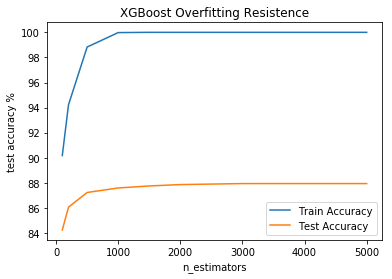

In [50]:
import matplotlib.pyplot as plt

x = [100, 200, 500, 1000, 1500, 2000, 3000, 5000]
y1 = [90.18, 94.23, 98.83, 99.98, 100.00, 100.00, 100.00, 100.00]
y2 = [84.25, 86.07, 87.24, 87.60, 87.76, 87.87, 87.95, 87.95]

plt.title("XGBoost Overfitting Resistence")
plt.xlabel('n_estimators')
plt.ylabel('test accuracy %')
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
plt.show()